# Combining Active Learning w/ Transfer Learning for improved image classification

#### Import necessary libraries for project

In [118]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


#### Data Loading
The next section consists of loading in CIFAR-10 and visualising for confirmation of import

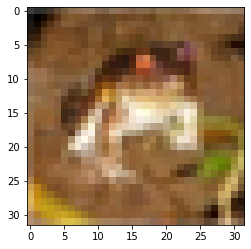

In [119]:
#Load in CIFAR-10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#Visualise first Image to see if it has loaded correctly
plt.imshow(x_train[0])
plt.show()

#### Data Preprocessing
This section contains preparing the data to be tested and trained. This section can greatly affect accuracy and model performance

In [120]:
#Reduce computational load by getting a random subsample of data
trainSamples = int(len(x_train) * 0.1)
#Select randomly from dataset the number derived from samples
randIndicies = np.random.choice(len(x_train), size=trainSamples, replace=False) 
#Fill new train data
x_train = x_train[randIndicies]
y_train = y_train[randIndicies]

#Fill testing data with same amount
testSamples = int(len(x_test) * 0.1)
randIndicies = np.random.choice(len(x_test), size=testSamples, replace=False)
#Fill new test data
x_test = x_test[randIndicies]
y_test = y_test[randIndicies]

Next the shape of the training and testing data is visualised.

In [121]:
#View Shape of test and train data
print("Training data shape:", x_train.shape)
print("Testing data shape:", x_train.shape)

Training data shape: (5000, 32, 32, 3)
Testing data shape: (5000, 32, 32, 3)


This section covers more preprocessing. Where the dataset is normailised and the labels are converted into one-hot encoded vectors

In [122]:
#Normalise the data into 0's and 1's
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Convert data labels into one-hot encoded vectors
classNumber = len(np.unique(y_train))

#Convert training labels to one-hot encoded vectors
y_train = to_categorical(y_train, classNumber)
y_test = to_categorical(y_test, classNumber)

#### Initial Simple Neural Network
a simple neural network is initialised to compare against the effectiveness of adding Active Learning and Transfer Learning

In [123]:
#Simple base nueral network model

#Model Architecture
model = Sequential([Flatten(input_shape=(32,32,3)),Dense(512, activation='relu'),
Dropout(0.3),Dense(classNumber,activation='softmax')])

#Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Create Early Stopper to stop ttraining if loss doesn't improve
stopperController = EarlyStopping(monitor='val_loss', patience=3)

#Train model on data
baseModel = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test,y_test), callbacks=[stopperController])


Epoch 1/50
157/157 [==============================] - 2s 8ms/step - loss: 2.3227 - accuracy: 0.2020 - val_loss: 2.0342 - val_accuracy: 0.2290
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 2.0439 - accuracy: 0.2398 - val_loss: 1.9418 - val_accuracy: 0.2850
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 2.0089 - accuracy: 0.2626 - val_loss: 1.9203 - val_accuracy: 0.3260
Epoch 4/50
157/157 [==============================] - 1s 8ms/step - loss: 1.9700 - accuracy: 0.2738 - val_loss: 1.9034 - val_accuracy: 0.3210
Epoch 5/50
157/157 [==============================] - 1s 9ms/step - loss: 1.9341 - accuracy: 0.2938 - val_loss: 1.8859 - val_accuracy: 0.3340
Epoch 6/50
157/157 [==============================] - 1s 9ms/step - loss: 1.9298 - accuracy: 0.2884 - val_loss: 1.8820 - val_accuracy: 0.3350
Epoch 7/50
157/157 [==============================] - 2s 10ms/step - loss: 1.9178 - accuracy: 0.2912 - val_loss: 1.8559 - val_accuracy: 0.3590
Epoch

#### Base Model Visualisations
This section contains visualisations of the performance of the base NN

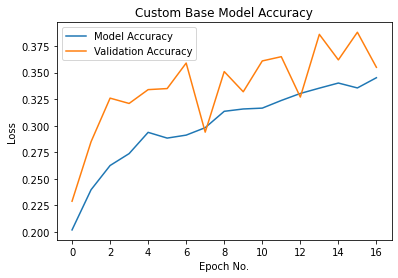

In [124]:
#Visualise Accuracy
plt.title('Custom Base Model Accuracy')
plt.plot(baseModel.history['accuracy'], label='Model Accuracy')
plt.plot(baseModel.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()

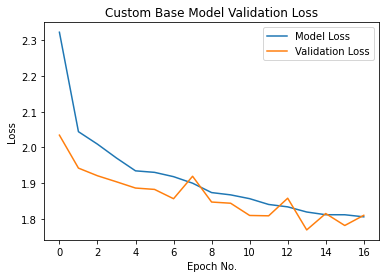

In [125]:
#Validation Loss
plt.title('Custom Base Model Validation Loss')
plt.plot(baseModel.history['loss'], label='Model Loss')
plt.plot(baseModel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()

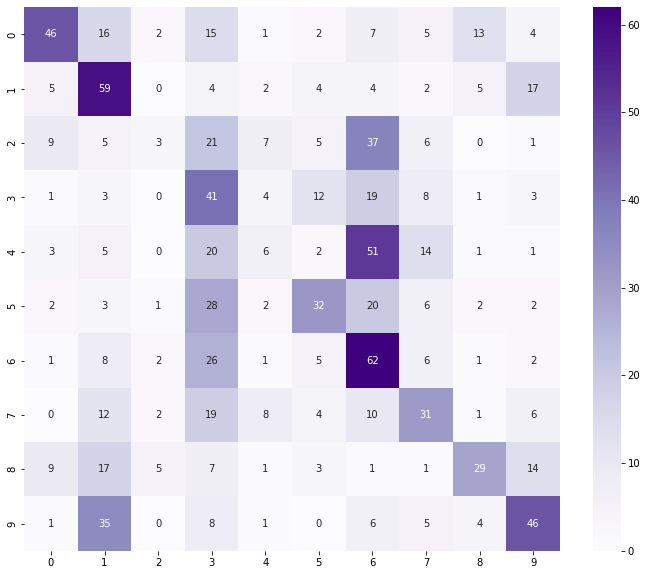

In [126]:
#Generate confusion matrix for the base model
y_pred = model.predict(x_test)
y_predictedClasses = np.argmax(y_pred, axis=-1)

#convert the one-hot encoded test labels to integers
y_testClasses = np.argmax(y_test, axis=-1)

#Plot the Confusion Matrix
confusionMatrix = confusion_matrix(y_testClasses, y_predictedClasses)
plt.figure(figsize=(12,10))
#Label plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#Create heatmap of data for visualisation
sns.heatmap(confusionMatrix, annot=True, cmap='Purples')
#display confusion Matrix
plt.show()

### Transfer Learning
the new model is initialised that utilises Transfer Learning in order to view the impact on classification accuracy

In [127]:

# Define the base model
base_model = VGG16(input_shape=(32, 32, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(classNumber, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# display the models summary
model.summary()

# Early stopping to monitor model
stopperController = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
TLmodel = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[stopperController])

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_37 (Flatten)        (None, 512)               0         
                                                                 
 dense_74 (Dense)            (None, 512)               262656    
                                                                 
 dropout_37 (Dropout)        (None, 512)               0         
                                                                 
 dense_75 (Dense)            (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
157/157 [===============

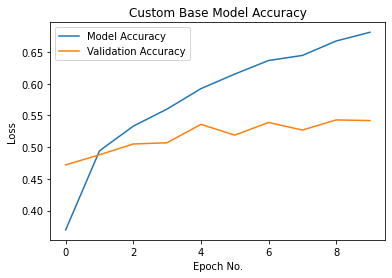

In [128]:
#Visualise Accuracy
plt.title('Custom Base Model Accuracy')
plt.plot(TLmodel.history['accuracy'], label='Model Accuracy')
plt.plot(TLmodel.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()


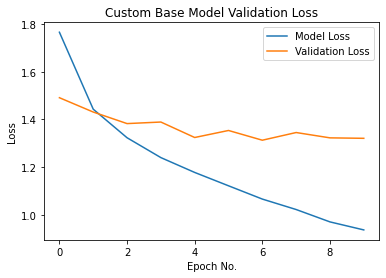

In [129]:
#Validation Loss
plt.title('Custom Base Model Validation Loss')
plt.plot(TLmodel.history['loss'], label='Model Loss')
plt.plot(TLmodel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()

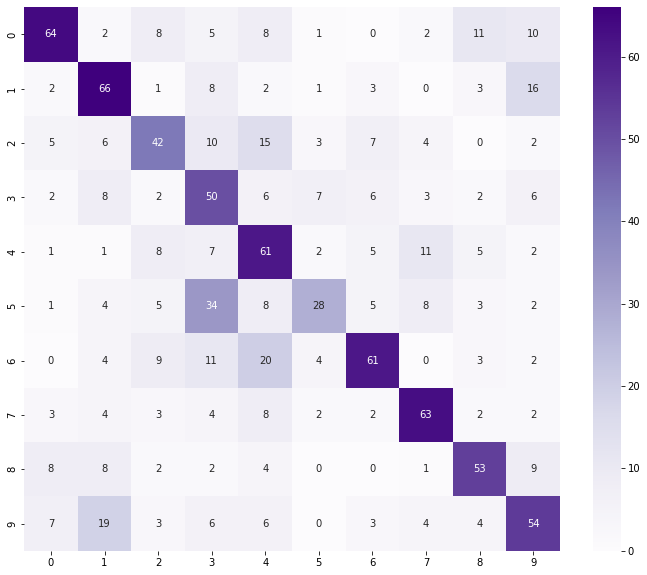

In [130]:
#Generate confusion matrix for the base model
y_pred = model.predict(x_test)
y_predictedClasses = np.argmax(y_pred, axis=-1)

#convert the one-hot encoded test labels to integers
y_testClasses = np.argmax(y_test, axis=-1)

#Plot the Confusion Matrix
confusionMatrix = confusion_matrix(y_testClasses, y_predictedClasses)
plt.figure(figsize=(12,10))
#Label plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#Create heatmap of data for visualisation
sns.heatmap(confusionMatrix, annot=True, cmap='Purples')
#display confusion Matrix
plt.show()

### Second Transfer Learning Model Tested
This section covers the testing of the second pretrained model 'ResNet50'

In [131]:
#ResNet50 model
# Load the InceptionV3 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the final model by adding the base model and the classification layers on top
model = Sequential([
  base_model,
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.5),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the data augmentation settings
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

# Use data augmentation on the labeled data
train_generator = datagen.flow(x_labeled, y_labeled, batch_size=32)

# Train the final model on the labeled and augmented data
TLmodel2= model.fit(train_generator, epochs=10, validation_data=(x_test, y_test))

# Evaluate the final model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
172/172 [==============================] - 20s 101ms/step - loss: 2.4303 - accuracy: 0.1029 - val_loss: 2.2914 - val_accuracy: 0.1120
Epoch 2/10
172/172 [==============================] - 16s 92ms/step - loss: 2.3026 - accuracy: 0.0984 - val_loss: 2.2961 - val_accuracy: 0.1010
Epoch 3/10
172/172 [==============================] - 17s 96ms/step - loss: 2.2977 - accuracy: 0.1040 - val_loss: 2.2871 - val_accuracy: 0.1120
Epoch 4/10
172/172 [==============================] - 15s 88ms/step - loss: 2.2938 - accuracy: 0.1111 - val_loss: 2.2814 - val_accuracy: 0.1360
Epoch 5/10
172/172 [==============================] - 15s 86ms/step - loss: 2.2877 - accuracy: 0.1205 - val_loss: 2.2733 - val_accuracy: 0.1410
Epoch 6/10
172/172 [==============================] - 15s 86ms/step - loss: 2.2865 - accuracy: 0.1222 - val_loss: 2.2926 - val_accuracy: 0.1040
Epoch 7/10
172/172 [==============================] - 15s 87ms/step - loss: 2.2908 - accuracy: 0.1145 - val_loss: 2.2572 - val_accuracy

#### ResNet50 Result Visualisation
This section covers the visualisation of the performance of ResNet50 with CIFAR-10

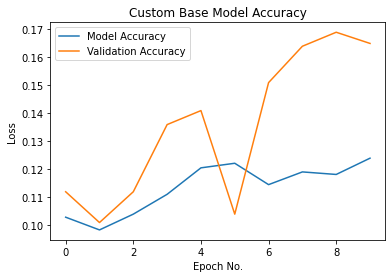

In [132]:
#Visualise Accuracy
plt.title('Custom Base Model Accuracy')
plt.plot(TLmodel2.history['accuracy'], label='Model Accuracy')
plt.plot(TLmodel2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()

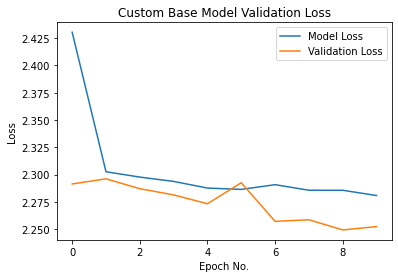

In [133]:
#Validation Loss
plt.title('Custom Base Model Validation Loss')
plt.plot(TLmodel2.history['loss'], label='Model Loss')
plt.plot(TLmodel2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()

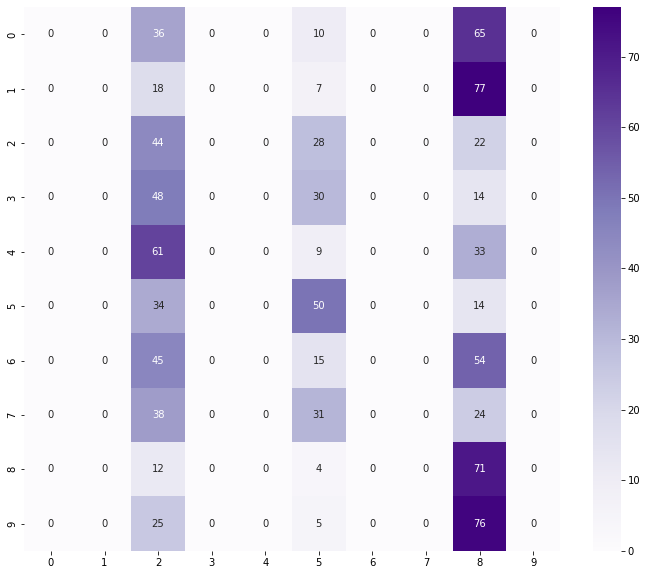

In [134]:
#Generate confusion matrix for the base model
y_pred = model.predict(x_test)
y_predictedClasses = np.argmax(y_pred, axis=-1)

#convert the one-hot encoded test labels to integers
y_testClasses = np.argmax(y_test, axis=-1)

#Plot the Confusion Matrix
confusionMatrix = confusion_matrix(y_testClasses, y_predictedClasses)
plt.figure(figsize=(12,10))
#Label plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#Create heatmap of data for visualisation
sns.heatmap(confusionMatrix, annot=True, cmap='Purples')
#display confusion Matrix
plt.show()

## Combining Active Learning With Transfer Learning
This seciton covers the combination of Uncertainty Sampling with Transfer Learning on CIFAR-10 to see if the classification accuracy is improved. 

In [137]:
# Define the number of labeled and unlabeled samples to start with
chosenLabelledSamples = 5000
chosenUnlabelledSamples = 45000

# Reload All CIFAR Data
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# Split the dataset into labeled and unlabeled sets
x_labeled = x_train_all[:chosenLabelledSamples]
y_labeled = y_train_all[:chosenLabelledSamples]
x_unlabeled = x_train_all[chosenLabelledSamples:chosenLabelledSamples+chosenUnlabelledSamples]
y_unlabeled = y_train_all[chosenLabelledSamples:chosenLabelledSamples+chosenUnlabelledSamples]

# Normalize the image pixel values
x_labeled = x_labeled.astype('float32') / 255
x_unlabeled = x_unlabeled.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert the labels to one-hot encoded vectors as before
classNumber = len(np.unique(y_train_all))
y_labeled = to_categorical(y_labeled, classNumber)
y_unlabeled = to_categorical(y_unlabeled, classNumber)
y_test = to_categorical(y_test, classNumber)

# Define the VGG16 base model
TLaALmodel = VGG16(input_shape=(32, 32, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in TLaALmodel.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    TLaALmodel,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(classNumber, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
earlyStopper = EarlyStopping(monitor='val_loss', patience=5)

# Train the model on the initial labeled set
model.fit(x_labeled, y_labeled, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[earlyStopper])

# Define the number of iterations for active learning
ALloopIterations = 5

for i in range(ALloopIterations):
    # Use the trained model to make predictions on the pool of unlabeled data
    predictions = model.predict(x_unlabeled)
    
    # Calculate the uncertainty of each prediction using entropy
    uncertainties = -np.sum(predictions * np.log(predictions), axis=1)
    
    # Sort the pool of unlabeled data by their uncertainty scores
    sorted_indices = np.argsort(uncertainties)
    
    # Select a subset of the most uncertain samples to be labeled
    num_samples_to_label = 500
    labeled_indices = sorted_indices[-num_samples_to_label:]
    x_labeled = np.concatenate([x_labeled, x_unlabeled[labeled_indices]])
    y_labeled = np.concatenate([y_labeled, y_unlabeled[labeled_indices]])
    
    # Remove the newly labeled samples from the pool of unlabeled data
    x_unlabeled = np.delete(x_unlabeled, labeled_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, labeled_indices, axis=0)

    # Train the model on the newly labeled set
    model.fit(x_labeled, y_labeled, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[earlyStopper])

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy:', test_acc)


Epoch 1/10
157/157 [==============================] - 53s 338ms/step - loss: 1.7562 - accuracy: 0.3736 - val_loss: 1.5031 - val_accuracy: 0.4779
Epoch 2/10
157/157 [==============================] - 55s 352ms/step - loss: 1.4178 - accuracy: 0.5038 - val_loss: 1.3970 - val_accuracy: 0.5065
Epoch 3/10
157/157 [==============================] - 64s 407ms/step - loss: 1.3130 - accuracy: 0.5468 - val_loss: 1.3678 - val_accuracy: 0.5211
Epoch 4/10
157/157 [==============================] - 62s 394ms/step - loss: 1.2253 - accuracy: 0.5716 - val_loss: 1.3366 - val_accuracy: 0.5329
Epoch 5/10
157/157 [==============================] - 57s 366ms/step - loss: 1.1621 - accuracy: 0.5936 - val_loss: 1.3514 - val_accuracy: 0.5243
Epoch 6/10
157/157 [==============================] - 59s 380ms/step - loss: 1.1072 - accuracy: 0.6120 - val_loss: 1.3153 - val_accuracy: 0.5381
Epoch 7/10
157/157 [==============================] - 58s 369ms/step - loss: 1.0586 - accuracy: 0.6300 - val_loss: 1.3263 - val_ac